# QF605 Part 3
## Convexity Correction 

Naming of Files and Variables: 
* File containing OIS discount factors (OISDiscountFactors), LIBOR discount factors (LIBORDiscountFactors) from Part 1 - 'Discount Factors.csv'
* File containing SABR data from Part 2 - 'data_SABR.csv'
* Output file contains CMS rates (CMS_Rate) and forward swap rates (Forward_Swap_Rate) - 'Rates.csv'


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

In [2]:
# Import OIS and LIBOR discount factors and Forward LIBOR rate from Part 1
df_comb = pd.read_csv('Discount Factors.csv')
df_comb.drop('Unnamed: 0', axis = 1, inplace = True)
df_comb.rename(columns = {"Forward LIBOR" : "F_LIBOR"}, inplace = True)
df_comb.head(15)

,Tenor,OISDiscountFactors,LIBORDiscountFactors
0,0.0,1.000000,1.000000
1,0.5,0.998752,0.987654
2,1.0,0.997009,0.972577
3,1.5,0.995270,0.957378
4,2.0,0.993531,0.942179
5,2.5,0.991773,0.926330
6,3.0,0.990015,0.910482
7,3.5,0.988066,0.894731
8,4.0,0.986117,0.878981
9,4.5,0.984150,0.863985


In [3]:
# Import SABR data from Part 2
df_SABRImpVol = pd.read_csv('data_SABR.csv')
df_SABRImpVol.drop('Unnamed: 0', axis = 1, inplace = True)
df_SABRImpVol.head(15)

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,Alpha,Rho,Nu,FSR
0,1Y,1Y,0.852100,0.649244,0.485885,0.342300,0.274718,0.212339,0.176342,0.185770,0.238179,0.289294,0.334656,0.139071,-0.633220,2.049466,0.032007
1,1Y,2Y,0.795508,0.628196,0.492548,0.376302,0.325071,0.281848,0.254519,0.249436,0.277820,0.317316,0.355440,0.184646,-0.525118,1.677430,0.033259
2,1Y,3Y,0.717213,0.577409,0.464131,0.368890,0.328342,0.295084,0.273235,0.265725,0.281280,0.310833,0.341674,0.196851,-0.482845,1.438142,0.034011
3,1Y,5Y,0.545014,0.448515,0.370492,0.306643,0.280645,0.260099,0.246637,0.241045,0.248039,0.266158,0.286839,0.178052,-0.414426,1.064877,0.035255
4,1Y,10Y,0.409542,0.350648,0.303771,0.267954,0.254733,0.245122,0.239316,0.237128,0.241125,0.251517,0.264376,0.171097,-0.264557,0.778081,0.038428
5,5Y,1Y,0.623919,0.514960,0.420888,0.337534,0.300096,0.267197,0.242232,0.229332,0.235992,0.260114,0.286974,0.166535,-0.585217,1.339732,0.039274
6,5Y,2Y,0.557235,0.474891,0.404990,0.345230,0.319420,0.297064,0.279127,0.266603,0.258398,0.265891,0.280117,0.199503,-0.546899,1.061928,0.040075
7,5Y,3Y,0.521672,0.450471,0.390606,0.340045,0.318345,0.299434,0.283804,0.271959,0.260239,0.261425,0.269763,0.210367,-0.549848,0.936740,0.040072
8,5Y,5Y,0.415678,0.366746,0.326197,0.292705,0.278573,0.266296,0.256000,0.247793,0.237671,0.234852,0.237089,0.191124,-0.511628,0.671316,0.041093
9,5Y,10Y,0.341557,0.309482,0.283273,0.262126,0.253360,0.245787,0.239401,0.234183,0.227065,0.223810,0.223520,0.177442,-0.440745,0.493883,0.043634


In [4]:
# Extract SABR parameters (alpha, rho, nu) into dataframe for interpolation
# Set index as expiry and column as tenors 
df_alpha = pd.DataFrame(data = df_SABRImpVol['Alpha'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
df_rho   = pd.DataFrame(data = df_SABRImpVol['Rho'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
df_nu    = pd.DataFrame(data = df_SABRImpVol['Nu'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])

In [5]:
print(df_alpha)

          1         2         3         5         10
1   0.139071  0.184646  0.196851  0.178052  0.171097
5   0.166535  0.199503  0.210367  0.191124  0.177442
10  0.177518  0.195014  0.207150  0.201541  0.180205


In [6]:
print(df_rho)

          1         2         3         5         10
1  -0.633220 -0.525118 -0.482845 -0.414426 -0.264557
5  -0.585217 -0.546899 -0.549848 -0.511628 -0.440745
10 -0.545692 -0.543819 -0.550697 -0.562603 -0.507723


In [7]:
print(df_nu)

          1         2         3         5         10
1   2.049466  1.677430  1.438142  1.064877  0.778081
5   1.339732  1.061928  0.936740  0.671316  0.493883
10  1.007072  0.924870  0.868996  0.719896  0.579627


### Interpolation

In [8]:
# Linear interpolation of LIBOR discount factors  
def LIBORDF(T):
    x = list(df_comb['Tenor'])
    y = list(df_comb['LIBORDiscountFactors'])
    return np.interp(T, x, y)

# Linear interpolation of OIS discount factors  
def OISDF(T):
    x = list(df_comb['Tenor'])
    y = list(df_comb['OISDiscountFactors'])
    return np.interp(T, x, y)

In [9]:
# Cubic Spline interpolation of SABR parameters
def SABRParams(expiry, tenor, data):
    splied_from_expiry = []
    for i in [1,2,3,5,10]:
        result = CubicSpline([1, 5, 10], data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(5):
        extract.append(splied_from_expiry[i](expiry))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(tenor))


In [10]:
x_range = np.arange(1,10.1,0.1)

          1         2         3         5         10
1   0.139071  0.184646  0.196851  0.178052  0.171097
5   0.166535  0.199503  0.210367  0.191124  0.177442
10  0.177518  0.195014  0.207150  0.201541  0.180205


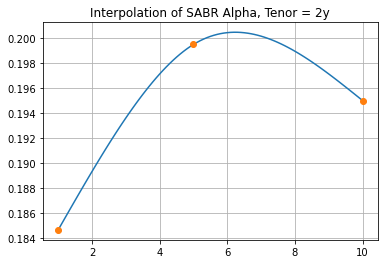

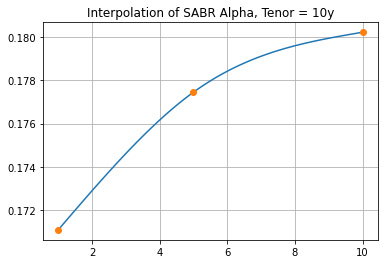

In [11]:
print(df_alpha)

plt.plot(x_range, [SABRParams(x, 2, df_alpha) for x in x_range])
plt.title("Interpolation of SABR Alpha, Tenor = 2y")
plt.plot(df_alpha.index,df_alpha[2],"o")
plt.grid()
plt.show()

plt.plot(x_range, [SABRParams(x, 10, df_alpha) for x in x_range])
plt.title("Interpolation of SABR Alpha, Tenor = 10y")
plt.plot(df_alpha.index,df_alpha[10],"o")
plt.grid()
plt.show()

          1         2         3         5         10
1  -0.633220 -0.525118 -0.482845 -0.414426 -0.264557
5  -0.585217 -0.546899 -0.549848 -0.511628 -0.440745
10 -0.545692 -0.543819 -0.550697 -0.562603 -0.507723


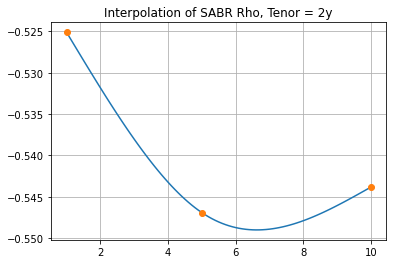

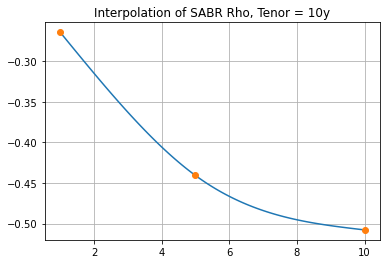

In [12]:
print(df_rho)

plt.plot(x_range, [SABRParams(x, 2, df_rho) for x in x_range])
plt.title("Interpolation of SABR Rho, Tenor = 2y")
plt.plot(df_rho.index,df_rho[2],"o")
plt.grid()
plt.show()

plt.plot(x_range, [SABRParams(x, 10, df_rho) for x in x_range])
plt.title("Interpolation of SABR Rho, Tenor = 10y")
plt.plot(df_rho.index,df_rho[10],"o")
plt.grid()
plt.show()

          1         2         3         5         10
1   2.049466  1.677430  1.438142  1.064877  0.778081
5   1.339732  1.061928  0.936740  0.671316  0.493883
10  1.007072  0.924870  0.868996  0.719896  0.579627


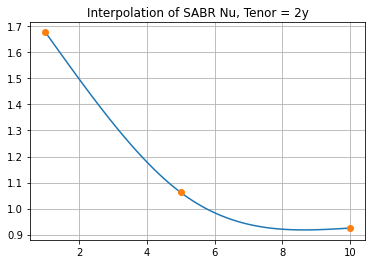

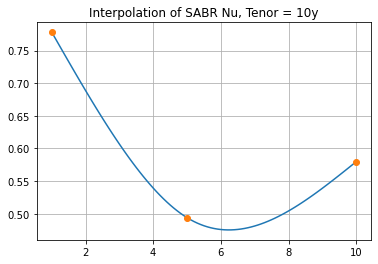

In [12]:
print(df_nu)

plt.plot(x_range, [SABRParams(x, 2, df_nu) for x in x_range])
plt.title("Interpolation of SABR Nu, Tenor = 2y")
plt.plot(df_nu.index,df_nu[2],"o")
plt.grid()
plt.show()

plt.plot(x_range, [SABRParams(x, 10, df_nu) for x in x_range])
plt.title("Interpolation of SABR Nu, Tenor = 10y")
plt.plot(df_nu.index,df_nu[10],"o")
plt.grid()
plt.show()

### Setting Functions

In [13]:
# Black76 model for IRR settled options
def Black76(F, K, T, r, sigma, option):
    d1 = (log(F/K)+(sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    if option == 'Call':
        return F*exp(-r*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    elif option == 'Put':
        return K*exp(-r*T)*norm.cdf(-d2) - F*exp(-r*T)*norm.cdf(-d1)

# SABR model 
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

$$ 
Forward\ LIBOR = L(T_{i-1} , T_{i}) = \frac{1}{\Delta} \frac{D_L(0, T_{i-1}) - D_L(0, T_i)}{D_L(0, T_i)}
$$

In [14]:
# Obtain forward LIBOR from discount factors
def forward_LIBOR(D1,D2,delta):
    forward_LIBOR = (1/delta)*((D1-D2)/D2)
    return forward_LIBOR

$$
Forward\ Swap\ Rate = \frac {PV_{Floating\ Leg}}{PV_{Fixed\ Leg}} = \frac{\sum_{n=i}^{N} D_0(0, T_i) \cdot L(T_i, T_{i-1}) \cdot \Delta}{\sum_{n=i}^{N} D_0(0,T_i) \cdot \Delta}
$$

In [15]:
def forward_SWAP_RATE(expiry, tenor, delta):   
    number = int(tenor/delta) # number of payments 
    float_leg, fixed_leg = 0, 0 # initialize floating and fixed legs
    
    for i in range(1,number+1):
        loc = expiry + i*delta
        # Floating Leg PV = Summation of OIS discount factor x forward LIBOR x delta (use interpolated discount factors)
        float_leg += OISDF(loc) * forward_LIBOR(LIBORDF(loc-delta),LIBORDF(loc),delta) * delta

    for i in range(1,number+1):
        loc = expiry + i*delta
        # Fixed Leg PV = Summation of OIS discount factor x delta (use interpolated discount factors)
        fixed_leg += OISDF(loc) * delta

    return float_leg / fixed_leg

$$
IRR(K) = \sum_{i=1}^{N \cdot m} \frac{\frac{1}{m}}{(1+\frac{K}{m})^i} 
$$ 

$$
IRR'(K) = \sum_{i=1}^{N \cdot m} (-i) \cdot \frac{(\frac{1}{m})^2}{(1+\frac{K}{m})^{(i+1)}} 
$$

$$
IRR''(K) = \sum_{i=1}^{N \cdot m} (-i) \cdot (-i-1) \cdot \frac{(\frac{1}{m})^3}{(1+\frac{K}{m})^{(i+2)}} 
$$

where $\frac{1}{m} = \Delta$

In [16]:
# Calculation of IRR(K), IRR'(K) and IRR''(K)

def IRR(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += Delta*(1 + K* Delta)**(-i)
    return total

def IRR_1st(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(Delta**2)*(1 + K* Delta)**(-i-1)
    return total

def IRR_2nd(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(-i-1)*(Delta**3)*(1 + K* Delta)**(-i-2)
    return total

$$ 
\begin{equation}
h^{\prime \prime}(K)=\frac{-\operatorname{IRR}^{\prime \prime}(K) \cdot K-2 \cdot \operatorname{IRR}^{\prime}(K)}{\operatorname{IRR}(K)^{2}}+\frac{2 \cdot \operatorname{IRR}^{\prime}(K)^{2} \cdot K}{\operatorname{IRR}(K)^{3}}
\end{equation}
$$

In [17]:
def h_2nd(Tenor, Delta, K):
    IRR0 = IRR(Tenor, Delta, K)
    IRR1 = IRR_1st(Tenor, Delta, K)
    IRR2 = IRR_2nd(Tenor, Delta, K) 
    return (-IRR2*K - 2*IRR1) / (IRR0**2) + 2*(IRR1**2)*K/(IRR0**3)

Using static-replication and choosing $F = S_{n, N}(0)$ as our expansion point:

\begin{equation}
\begin{aligned}
&V_{0}=D(0, T) g(F)+h^{\prime}(F)\left[V^{\text {pay }}(F)-V^{r e c}(F)\right] \\
&\quad+\int_{0}^{F} h^{\prime \prime}(K) V^{r e c}(K) d K+\int_{F^{\prime}}^{\infty} h^{\prime \prime}(K) V^{\text {pay }}(K) d K \\
&=D(0, T) g(F)+\int_{0}^{F} h^{\prime \prime}(K) V^{r e c}(K) d K+\int_{F}^{\infty} h^{\prime \prime}(K) V^{p a y}(K) d K
\end{aligned}
\end{equation}

IRR-settled option pricer for $V_{rec}$ or $V_{pay}$ is:

\begin{equation} 
V(K)=D(0, T) \cdot \operatorname{IRR}\left(S_{n, N}(0)\right) \cdot \operatorname{Black} 76\left(S_{n, N}(0), K, \sigma_{\mathrm{SABR}}, T\right)
\end{equation}

where $\sigma_{\mathrm{SABR}}$ is obtained from the SABR model.


In [18]:
def integrand(F, K, T, r, sigma, tenor, delta, option):
    irr = IRR(tenor, delta, F)
    h2 = h_2nd(tenor, delta, K)
    return h2 * Black76(F, K, T, r, sigma, option)

$$
CMS\ Rate = E^{T}\left[S_{n, N}(T)\right] = 
g(F)+\frac{1}{D_{0}(0, T)}\left[\int_{0}^{F} h^{\prime \prime}(K) V^{\text {rec }}(K) d K+\int_{F}^{\infty} h^{\prime \prime}(K) V^{\text {pay }}(K) d K\right]
$$

In [19]:
def CMS(expiry, tenor, delta):
    F       = forward_SWAP_RATE(expiry, tenor, delta)
    alpha   = SABRParams(expiry,tenor,df_alpha)
    rho     = SABRParams(expiry,tenor,df_rho)
    nu      = SABRParams(expiry,tenor,df_nu)
    VRec    = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Put'), 0, F)
    VPay    = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Call'), F, 0.1) 

    return F + VRec[0] + VPay[0]

PV of CMS Leg is the sum of the discounted values of the CMS rates, multiplied by day count fraction: 
\begin{equation}
PV_{CMS}=\sum_{i=1}^\frac{N}{\Delta} D_{0}\left(0, T_{i}\right) \cdot E^{T}\left[S_{n, N}(T)\right] \cdot \Delta
\end{equation}

In [20]:
def PV_CMS(tenor, cms_period, delta):
    n = int(cms_period/delta)
    pv = 0
    for i in range(1,n+1):
        loc = i*delta
        pv += OISDF(loc) * CMS(loc,tenor,delta) * delta 
    return pv

### Question 1

Using the SABR model calibrated in the previous question, value the following constant maturity swap (CMS) products:

* PV of a leg receiving CMS10y semi-annually over the next 5 years
* PV of a leg receiving CMS2y quarterly over the next 10 years

In [21]:
tenor = 10
cms_period = 5
delta = 0.5

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS10y semi-annually over the next 5 years = ',PV.round(5) )

PV of a leg receiving CMS10y semi-annually over the next 5 years =  0.20209


In [22]:
tenor = 2
cms_period = 10
delta = 0.25

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS2y quarterly over the next 10 years = ',PV.round(5) )

PV of a leg receiving CMS2y quarterly over the next 10 years =  0.38185


### Question 2

Compare the forward swap rates with the CMS rate:

* 1y x 1y, 1y x 2y, 1y x 3y, 1y x 5y, 1y x 10y
* 5y x 1y, 5y x 2y, 5y x 3y, 5y x 5y, 5y x 10y
* 10y x 1y, 10y x 2y, 10y x 3y, 10y x 5y, 10y x 10y

In [23]:
#calculate CMS rates
expiry = [1, 5, 10]
tenor = [1, 2, 3, 5, 10]
delta = 0.5

CMS_list = []
for i in expiry:
    for j in tenor:
        CMS_list.append(CMS(i,j,delta))
CMS_list

[0.03211967855565483,
 0.03338160398718786,
 0.034119621785810135,
 0.03532554709056438,
 0.03849569682879417,
 0.04012891909769689,
 0.040756265523186515,
 0.04066358393838474,
 0.041532028162479646,
 0.04405030075760411,
 0.043635033179426165,
 0.04432244987037833,
 0.04522537432129148,
 0.0472099310937907,
 0.05452749355998453]

In [24]:
Index = ['1 x 1', '1 x 2', '1 x 3', '1 x 5', '1 x 10',
         '5 x 1', '5 x 2', '5 x 3', '5 x 5', '5 x 10',
         '10 x 1', '10 x 2', '10 x 3', '10 x 5', '10 x 10']

In [25]:
comparison = pd.DataFrame({'CMS_Rate':CMS_list, 'Forward_Swap_Rate':df_SABRImpVol["FSR"].values }, index = Index)
comparison

,CMS_Rate,Forward_Swap_Rate
1 x 1,0.032120,0.032007
1 x 2,0.033382,0.033259
1 x 3,0.034120,0.034011
1 x 5,0.035326,0.035255
1 x 10,0.038496,0.038428
5 x 1,0.040129,0.039274
5 x 2,0.040756,0.040075
5 x 3,0.040664,0.040072
5 x 5,0.041532,0.041093
5 x 10,0.044050,0.043634


In [26]:
comparison["Difference"] = comparison["CMS_Rate"] - comparison["Forward_Swap_Rate"]
comparison

,CMS_Rate,Forward_Swap_Rate,Difference
1 x 1,0.032120,0.032007,0.000113
1 x 2,0.033382,0.033259,0.000122
1 x 3,0.034120,0.034011,0.000109
1 x 5,0.035326,0.035255,0.000070
1 x 10,0.038496,0.038428,0.000068
5 x 1,0.040129,0.039274,0.000855
5 x 2,0.040756,0.040075,0.000681
5 x 3,0.040664,0.040072,0.000591
5 x 5,0.041532,0.041093,0.000439
5 x 10,0.044050,0.043634,0.000416


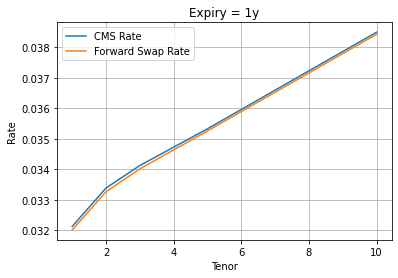

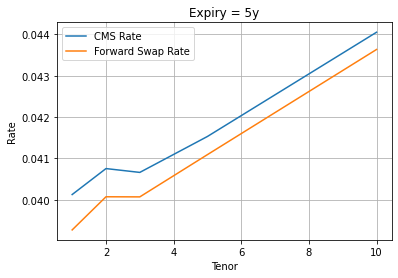

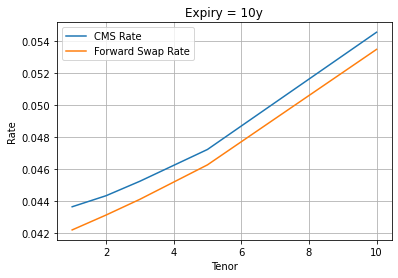

In [27]:
title_list = ['Expiry = 1y', 'Expiry = 5y', 'Expiry = 10y']
for i in range(3):
    plt.plot(tenor,comparison["CMS_Rate"][i*5:(i+1)*5],label="CMS Rate")
    plt.plot(tenor,comparison["Forward_Swap_Rate"][i*5:(i+1)*5],label="Forward Swap Rate")
    plt.title(title_list[i])
    plt.ylabel("Rate")
    plt.xlabel("Tenor")
    plt.legend()
    plt.grid()
    plt.show()

In [28]:
comparison.to_csv("Rates.csv")

                        ----- END OF PART 3 -----